<a href="https://colab.research.google.com/github/ranimeshehata/Feed-Forward-Neural-Network-on-MNIST/blob/main/Copy_of_Feed_Forward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Feed Forward Neural Network on MNIST</h1>

<h3>Imports</h3>

In [ ]:
import torch
import time
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


In [ ]:
# setting the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<h3>Preprocessing the data</h3>

In [ ]:
# normalizing the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


<h3>Downloading the dataset</h3>

In [ ]:
train_val_dataset = datasets.MNIST(root='./dataset', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./dataset', train=False, download=True, transform=transform)
combined_dataset = ConcatDataset([train_val_dataset, test_dataset])


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 54.9MB/s]


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.21MB/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.2MB/s]


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.25MB/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [ ]:
print(f"Train dataset size: {len(train_val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Combined dataset size: {len(combined_dataset)}")

Train dataset size: 60000
Test dataset size: 10000
Combined dataset size: 70000


<h3>HyperParameters</h3>

In [ ]:
batch_size = 128  # change between 32, 64, 128, 256
num_classes = 10
input_size = 28 * 28
num_epochs = 100
l2_lambda = 0.0001

<h3>Splitting the data</h3>

In [ ]:
# calculating split sizes
train_datset_size = int(0.6 * len(combined_dataset))
val_dataset_size = int(0.2 * len(combined_dataset))
test_dataset_size = len(combined_dataset) - train_datset_size - val_dataset_size

# printing split sizes
print(train_datset_size, val_dataset_size, test_dataset_size)

42000 14000 14000


In [ ]:
# splitting the dataset
train_dataset_idx, temp_dataset_idx = train_test_split(list(range(len(combined_dataset))), train_size=train_datset_size, random_state=5)
val_dataset_idx, test_dataset_idx = train_test_split(temp_dataset_idx, test_size=0.5, random_state=5)

print(len(train_dataset_idx), len(val_dataset_idx), len(test_dataset_idx))

42000 14000 14000


In [ ]:
# make subset of the dataset based on the split indices
train_dataset = Subset(combined_dataset, train_dataset_idx)
val_dataset = Subset(combined_dataset, val_dataset_idx)
test_dataset = Subset(combined_dataset, test_dataset_idx)

print(len(train_dataset), len(val_dataset), len(test_dataset))

42000 14000 14000


In [ ]:
# creating dataloaders
train_dataset_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataset_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_dataset_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print(len(train_dataset_loader), len(val_dataset_loader), len(test_dataset_loader))

329 110 110


In [ ]:
x, y = next(iter(train_dataset_loader))

print(x.shape)  # [batch_size, channels, height, width]
print(y.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


<h2>Feed Forward Neural Network</h2>

<h3>1. Define the Feed Forward Neural Network model</h3>

- **Initialization (`__init__` method)**:
    - The constructor initializes the network's architecture.
    - It takes the number of input features, hidden layer sizes, and the number of output features as arguments.
    - It initializes the weights and biases for each layer using random values.
    - MNIST images are 28x28 pixels, 10 classes

- **Forward Pass (`forward` method)**:
    - This method performs the forward pass of the network.
    - It takes an input tensor and passes it through each layer, applying the activation function (usually ReLU for hidden layers and softmax for the output layer).

- **Activation Functions**:
    - ReLU (Rectified Linear Unit) is used for hidden layers to introduce non-linearity.
    - Softmax is used for the output layer to convert the output logits into probabilities.


In [ ]:
class FeedForwardNeuralNetwork(torch.nn.Module):
    def __init__(self, input_size, h1, h2, num_classes):
        super(FeedForwardNeuralNetwork, self).__init__()
        self.hidden1 = torch.nn.Linear(input_size, h1)
        self.hidden2 = torch.nn.Linear(h1, h2)
        self.output = torch.nn.Linear(h2, num_classes)

    def forward(self, x): # x is the input = image
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.relu(self.hidden1(x))
        x = torch.nn.functional.relu(self.hidden2(x))
        return self.output(x)

<h3>2. Training the Model</h3>

**First: Initialize model, loss function, and optimizer:**
- Create an instance of the FeedForward class by specifying the input size, hidden layer sizes, and output size.
- Use the forward method to perform a forward pass with your input data.
    - Model: Feed Forward Neural Network <br/>
    - Loss Function: Cross-Entropy <br/>
    - Optimizer: Stochastic Gradient Descent (SGD) <br/>

- **Training Loop:** <br/>
```
for epoch in range(num_epochs):
    model.train()
```

- **y_train** is the ground truth label for the current batch
- **outputs** is the predicted label for the current batch

- clear the gradients of all optimized variables to prevent accumulation of gradients from previous batches ``` optimizer.zero_grad() ```

- forward pass of the model on the current batch ``` outputs = model(x_train) ```

- compute the loss between the predicted label (outputs) and the ground truth label (y_train) ``` loss = criterion(outputs, y_train) ```
<hr/>

**Compute Gradients:**

- compute the gradients of the loss with respect to the model parameters ``` loss.backward() ```
- update the model parameters based on the computed gradients ``` optimizer.step() ```

<hr/>

<h3>3. Evaluating the model on Validation Dataset</h3>

**"The validation results are used to tune hyperparameters and select the best model based on its performance on the validation dataset."**

- **Model Evaluation**: Set the model to evaluation mode using `model.eval()`. This ensures that layers like dropout and batch normalization behave appropriately during validation.
- **Loss Calculation**: Compute the loss on the validation dataset using the same loss function as used for training.
- **Accuracy Calculation**: Calculate the accuracy by comparing the predicted labels with the true labels.
- **No Gradient Calculation**: Use `torch.no_grad()` to disable gradient calculation, which reduces memory consumption and speeds up computation during validation.
- **Performance Monitoring**: Track the validation loss and accuracy for each epoch to monitor the model's performance over time.

<hr/>

<h3>4. Evaluating the model on Test Dataset</h3>

**"After training and validating the model, we evaluate its performance on the test dataset. This helps us understand how well the model generalizes to unseen data."**

- **Model Evaluation**: Set the model to evaluation mode using `model.eval()`. This ensures that layers like dropout and batch normalization behave appropriately during testing.\n",
- **No Gradient Calculation**: Use `torch.no_grad()` to disable gradient calculation, which reduces memory consumption and speeds up computation during testing.
- **Prediction**: Pass the test data through the model to obtain predictions.
- **Accuracy Calculation**: Calculate the accuracy by comparing the predicted labels with the true labels.
``accuracy = accuracy_score(y_true, y_pred) ``

<hr/>

<h3>5. Confusion Matrix for the Test Dataset Predictions</h3>

**"A confusion matrix is a useful tool for evaluating the performance of a classification model. It provides a detailed breakdown of the model's predictions compared to the actual labels. The confusion matrix helps in understanding the types of errors the model is making and which classes are being misclassified."**

- **Generate Confusion Matrix**: Calculate the confusion matrix using the true labels and the predicted labels. This matrix shows the counts of true positive, true negative, false positive, and false negative predictions for each class.
- **Visualization**: Visualize the confusion matrix using a heatmap to make it easier to interpret. The heatmap provides a color-coded representation of the matrix, where the intensity of the color represents the count of predictions.


<hr/>

<h3>6. Visualization & Plotting</h3>

**"Visualization and plotting are essential for understanding the performance of the model during training and evaluation. They help in identifying trends, patterns, and potential issues, helping to make informed decisions about model tuning and improvements."**

- **Training and Validation Loss**: Plot the training and validation loss over epochs to monitor the model's learning process. This helps in identifying issues like overfitting or underfitting.
- **Training and Validation Accuracy**: Plot the training and validation accuracy over epochs to evaluate the model's performance. This helps in understanding how well the model is generalizing to the validation data.
- **Learning Rate Comparison**: Plot the training and validation metrics for different learning rates to compare their performance. This helps in identifying the best learning rate for the model.




Learning rate: 0.01 without L2 regularization
Epoch 1/100
Epoch 1/100 Training Loss: 1.8246
Epoch 1/100 Training Accuracy: 42.22%
Epoch 1/100 Validation Loss: 1.1322
Epoch 1/100 Validation Accuracy: 72.61%
--------------------------------------------------
Epoch 2/100
Epoch 2/100 Training Loss: 0.8076
Epoch 2/100 Training Accuracy: 78.12%
Epoch 2/100 Validation Loss: 0.6257
Epoch 2/100 Validation Accuracy: 82.51%
--------------------------------------------------
Epoch 3/100
Epoch 3/100 Training Loss: 0.5359
Epoch 3/100 Training Accuracy: 84.97%
Epoch 3/100 Validation Loss: 0.4834
Epoch 3/100 Validation Accuracy: 86.65%
--------------------------------------------------
Epoch 4/100
Epoch 4/100 Training Loss: 0.4295
Epoch 4/100 Training Accuracy: 87.71%
Epoch 4/100 Validation Loss: 0.4168
Epoch 4/100 Validation Accuracy: 88.31%
--------------------------------------------------
Epoch 5/100
Epoch 5/100 Training Loss: 0.3780
Epoch 5/100 Training Accuracy: 89.06%
Epoch 5/100 Validation Los

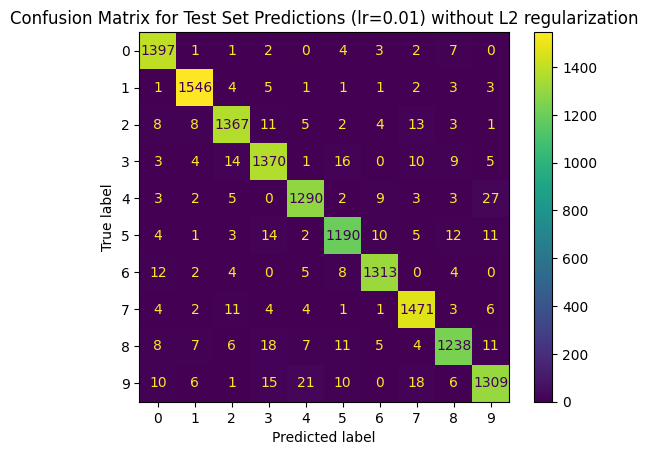

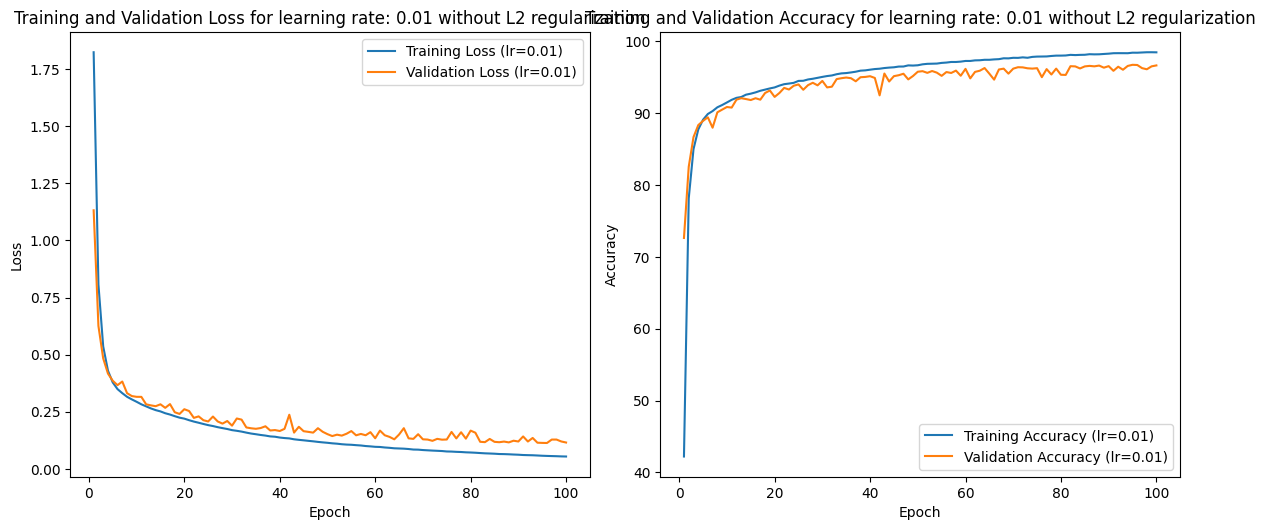

In [ ]:
dict = {}
results = {}
for lr in [0.01]:
    print(f"Learning rate: {lr} without L2 regularization")
    model = FeedForwardNeuralNetwork(input_size, 64, 32, num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    start = time.time()

    for epoch in range(num_epochs):     # loop over the dataset num_epochs times
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        epoch_train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (x_train, y_train) in enumerate(train_dataset_loader):
            x_train, y_train = x_train.to(device), y_train.to(device)
            optimizer.zero_grad()

            # outputs = logits = values before, with shape (batch_size, num_classes)
            outputs = model(x_train)
            batch_train_loss = criterion(outputs, y_train)

            # calculate the gradients
            predicted = torch.argmax(outputs, dim=1)
            train_total += y_train.size(0)
            train_correct += (predicted == y_train).sum().item()
            batch_train_loss.backward()     # dl/dwi
            optimizer.step()  # update weights, W = W - lr * gradient
            epoch_train_loss += batch_train_loss.item()   # update loss of current epoch with loss for current batch

        # calculate the average loss and accuracy for the current epoch
        epoch_train_loss /= len(train_dataset_loader)
        train_losses.append(epoch_train_loss)
        train_accuracy = 100 * (train_correct / train_total)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        epoch_val_loss = 0.0
        val_correct = 0
        val_total = 0 # total number of examples in the dataset

        with torch.no_grad():
            for x_val, y_val in val_dataset_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                outputs = model(x_val)
                batch_val_loss = criterion(outputs, y_val)
                epoch_val_loss += batch_val_loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += y_val.size(0)
                val_correct += (predicted == y_val).sum().item()

        epoch_val_loss /= len(val_dataset_loader)
        val_losses.append(epoch_val_loss)
        val_accuracy = 100 * (val_correct / val_total)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} Training Loss: {epoch_train_loss:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs} Training Accuracy: {train_accuracy:.2f}%")
        print(f"Epoch {epoch+1}/{num_epochs} Validation Loss: {epoch_val_loss:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs} Validation Accuracy: {val_accuracy:.2f}%")
        print("-" * 50)

    end = time.time()
    total_duration = end - start
    print(f"Training time for learning rate {lr}: {total_duration:.2f} seconds without L2 regularization")

    # store the training and validation results for the current learning rate
    dict[lr] = (epoch_train_loss, train_accuracy, epoch_val_loss, val_accuracy)
    results[lr] = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'total_duration': total_duration
    }

    # Evaluate the model on the test dataset
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x_test, y_test in test_dataset_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            outputs = model(x_test)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_test.cpu().numpy()) # convert to numpy array from tensor
            y_pred.extend(predicted.cpu().numpy())

    # calculate the test accuracy
    accuracy = accuracy_score(y_true, y_pred)
    results[lr]['test_accuracy'] = accuracy * 100
    print(f"Test Accuracy: {accuracy * 100:.2f}% for learning rate: {lr} without L2 regularization")
    print("-" * 50)

    print("Results Summary for learning rate: ", lr, " without L2 regularization")
    print(f"Training Loss: {dict[lr][0]: .4f}")
    print(f"Training Accuracy: {dict[lr][1]: .4f}%")
    print(f"Validation Loss: {dict[lr][2]: .4f}")
    print(f"Validation Accuracy: {dict[lr][3]: .4f}%")
    print(f"Test Accuracy: {results[lr]['test_accuracy']:.2f}%")
    print(f"Total Training Time: {results[lr]['total_duration']:.2f} seconds")
    print("-" * 50)

    # plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(num_classes)))
    disp.plot(cmap='viridis', values_format='d')
    plt.title(f"Confusion Matrix for Test Set Predictions (lr={lr}) without L2 regularization")
    plt.show()


    # plot the training and validation loss & accuracy for the current learning rate
    plt.figure(figsize=(12, 10))
    epochs = range(1, num_epochs + 1)

    # plot training and validation loss
    plt.subplot(2, 2, 1)
    plt.title(f"Training and Validation Loss for learning rate: {lr} without L2 regularization")
    plt.plot(epochs, results[lr]['train_losses'], label=f'Training Loss (lr={lr})')
    plt.plot(epochs, results[lr]['val_losses'], label=f'Validation Loss (lr={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # plot training and validation accuracy
    plt.subplot(2, 2, 2)
    plt.title(f"Training and Validation Accuracy for learning rate: {lr } without L2 regularization")
    plt.plot(epochs, results[lr]['train_accuracies'], label=f'Training Accuracy (lr={lr})')
    plt.plot(epochs, results[lr]['val_accuracies'], label=f'Validation Accuracy (lr={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

<h2>Results Summary</h2>

In [ ]:
print("Final Results for all learning rates without L2 Reqularization:")
for lr in [0.01]:
    print(f"learning_rate = {lr}")
    print(f"Training Loss: {dict[lr][0]: .4f}")
    print(f"Training Accuracy: {dict[lr][1]: .4f}%")
    print(f"Validation Loss: {dict[lr][2]: .4f}")
    print(f"Validation Accuracy: {dict[lr][3]: .4f}%")
    print(f"Test Accuracy: {results[lr]['test_accuracy']:.2f}%")
    print(f"Total Training Time: {results[lr]['total_duration']:.2f} seconds")

    print("-" * 50)

Final Results for all learning rates without L2 Reqularization:
learning_rate = 0.01
Training Loss:  0.0536
Training Accuracy:  98.4357%
Validation Loss:  0.1149
Validation Accuracy:  96.6143%
Test Accuracy: 96.36%
Total Training Time: 1528.13 seconds
--------------------------------------------------


<h2>Best Learning Rate</h2>

In [ ]:
# Find the best learning rate based on the test accuracy
best_lr = None
best_accuracy = 0

for lr in results.keys():
    if results[lr]['test_accuracy'] > best_accuracy:
        best_accuracy = results[lr]['test_accuracy']
        best_lr = lr

print(f"Best Learning Rate: {best_lr} with Test Accuracy: {best_accuracy:.2f}% without L2 regularization")

Best Learning Rate: 0.01 with Test Accuracy: 96.36% without L2 regularization


<h2>Adding L2 Reqularization</h2>

with lambda = 0.0001

Learning rate: 0.01 with L2 regularization
Epoch 1/100
Epoch 1/100 Training Loss: 1.8835
Epoch 1/100 Training Accuracy: 47.43%
Epoch 1/100 Validation Loss: 1.1954
Epoch 1/100 Validation Accuracy: 72.01%
--------------------------------------------------
Epoch 2/100
Epoch 2/100 Training Loss: 0.7735
Epoch 2/100 Training Accuracy: 80.95%
Epoch 2/100 Validation Loss: 0.5606
Epoch 2/100 Validation Accuracy: 84.83%
--------------------------------------------------
Epoch 3/100
Epoch 3/100 Training Loss: 0.4822
Epoch 3/100 Training Accuracy: 86.81%
Epoch 3/100 Validation Loss: 0.4779
Epoch 3/100 Validation Accuracy: 86.70%
--------------------------------------------------
Epoch 4/100
Epoch 4/100 Training Loss: 0.4072
Epoch 4/100 Training Accuracy: 88.40%
Epoch 4/100 Validation Loss: 0.4032
Epoch 4/100 Validation Accuracy: 88.20%
--------------------------------------------------
Epoch 5/100
Epoch 5/100 Training Loss: 0.3720
Epoch 5/100 Training Accuracy: 89.15%
Epoch 5/100 Validation Loss: 

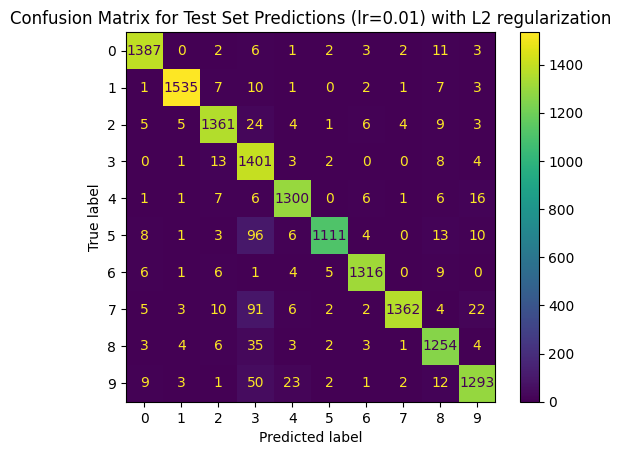

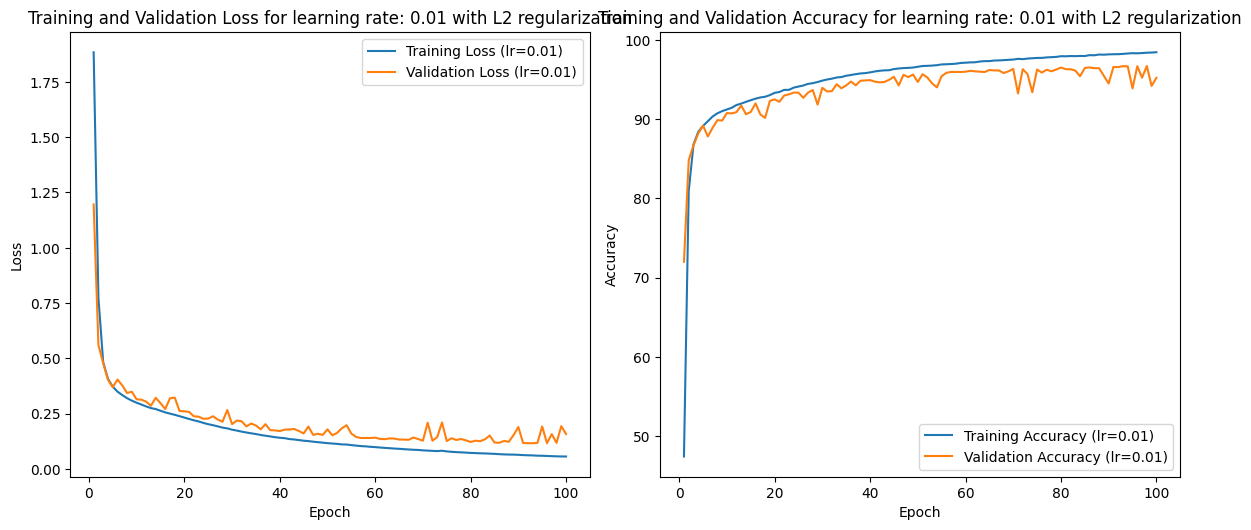

In [ ]:
dict = {}
results = {}
for lr in [0.01]:
    print(f"Learning rate: {lr} with L2 regularization")
    model = FeedForwardNeuralNetwork(input_size, 64, 32, num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=l2_lambda)
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    start = time.time()

    for epoch in range(num_epochs):     # loop over the dataset num_epochs times
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        epoch_train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (x_train, y_train) in enumerate(train_dataset_loader):
            x_train, y_train = x_train.to(device), y_train.to(device)
            optimizer.zero_grad()

            # outputs = logits = values before, with shape (batch_size, num_classes)
            outputs = model(x_train)
            batch_train_loss = criterion(outputs, y_train)

            # calculate the gradients
            predicted = torch.argmax(outputs, dim=1)
            train_total += y_train.size(0)
            train_correct += (predicted == y_train).sum().item()
            batch_train_loss.backward()     # dl/dwi
            optimizer.step()  # update weights, W = W - lr * gradient
            epoch_train_loss += batch_train_loss.item()   # update loss of current epoch with loss for current batch

        # calculate the average loss and accuracy for the current epoch
        epoch_train_loss /= len(train_dataset_loader)
        train_losses.append(epoch_train_loss)
        train_accuracy = 100 * (train_correct / train_total)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        epoch_val_loss = 0.0
        val_correct = 0
        val_total = 0 # total number of examples in the dataset

        with torch.no_grad():
            for x_val, y_val in val_dataset_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                outputs = model(x_val)
                batch_val_loss = criterion(outputs, y_val)
                epoch_val_loss += batch_val_loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += y_val.size(0)
                val_correct += (predicted == y_val).sum().item()

        epoch_val_loss /= len(val_dataset_loader)
        val_losses.append(epoch_val_loss)
        val_accuracy = 100 * (val_correct / val_total)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} Training Loss: {epoch_train_loss:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs} Training Accuracy: {train_accuracy:.2f}%")
        print(f"Epoch {epoch+1}/{num_epochs} Validation Loss: {epoch_val_loss:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs} Validation Accuracy: {val_accuracy:.2f}%")
        print("-" * 50)

    end = time.time()
    total_duration = end - start
    print(f"Training time for learning rate {lr}: {total_duration:.2f} seconds with L2 regularization")

    # store the training and validation results for the current learning rate
    dict[lr] = (epoch_train_loss, train_accuracy, epoch_val_loss, val_accuracy)
    results[lr] = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'total_duration': total_duration
    }

    # Evaluate the model on the test dataset
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x_test, y_test in test_dataset_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            outputs = model(x_test)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_test.cpu().numpy()) # convert to numpy array from tensor
            y_pred.extend(predicted.cpu().numpy())

    # calculate the test accuracy
    accuracy = accuracy_score(y_true, y_pred)
    results[lr]['test_accuracy'] = accuracy * 100
    print(f"Test Accuracy: {accuracy * 100:.2f}% for learning rate: {lr} with L2 regularization")
    print("-" * 50)

    print("Results Summary for learning rate: ", lr, " with L2 regularization")
    print(f"Training Loss: {dict[lr][0]: .4f}")
    print(f"Training Accuracy: {dict[lr][1]: .4f}%")
    print(f"Validation Loss: {dict[lr][2]: .4f}")
    print(f"Validation Accuracy: {dict[lr][3]: .4f}%")
    print(f"Test Accuracy: {results[lr]['test_accuracy']:.2f}%")
    print(f"Total Training Time: {results[lr]['total_duration']:.2f} seconds")
    print("-" * 50)

    # plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(num_classes)))
    disp.plot(cmap='viridis', values_format='d')
    plt.title(f"Confusion Matrix for Test Set Predictions (lr={lr}) with L2 regularization")
    plt.show()


    # plot the training and validation loss & accuracy for the current learning rate
    plt.figure(figsize=(12, 10))
    epochs = range(1, num_epochs + 1)

    # plot training and validation loss
    plt.subplot(2, 2, 1)
    plt.title(f"Training and Validation Loss for learning rate: {lr} with L2 regularization")
    plt.plot(epochs, results[lr]['train_losses'], label=f'Training Loss (lr={lr})')
    plt.plot(epochs, results[lr]['val_losses'], label=f'Validation Loss (lr={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # plot training and validation accuracy
    plt.subplot(2, 2, 2)
    plt.title(f"Training and Validation Accuracy for learning rate: {lr} with L2 regularization")
    plt.plot(epochs, results[lr]['train_accuracies'], label=f'Training Accuracy (lr={lr})')
    plt.plot(epochs, results[lr]['val_accuracies'], label=f'Validation Accuracy (lr={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

<h2>Results Summary</h2>

In [ ]:
print("Final Results for all learning rates with L2 Reqularization:")
for lr in [0.01]:
    print(f"learning_rate = {lr}")
    print(f"Training Loss: {dict[lr][0]: .4f}")
    print(f"Training Accuracy: {dict[lr][1]: .4f}%")
    print(f"Validation Loss: {dict[lr][2]: .4f}")
    print(f"Validation Accuracy: {dict[lr][3]: .4f}%")
    print(f"Test Accuracy: {results[lr]['test_accuracy']:.2f}%")
    print(f"Total Training Time: {results[lr]['total_duration']:.2f} seconds")

    print("-" * 50)

Final Results for all learning rates with L2 Reqularization:
learning_rate = 0.01
Training Loss:  0.0562
Training Accuracy:  98.4452%
Validation Loss:  0.1578
Validation Accuracy:  95.2143%
Test Accuracy: 95.14%
Total Training Time: 1544.62 seconds
--------------------------------------------------


<h2>Best Learning Rate</h2>

In [ ]:
# Find the best learning rate based on the test accuracy
best_lr = None
best_accuracy = 0

for lr in results.keys():
    if results[lr]['test_accuracy'] > best_accuracy:
        best_accuracy = results[lr]['test_accuracy']
        best_lr = lr

print(f"Best Learning Rate: {best_lr} with Test Accuracy: {best_accuracy:.2f}% with L2 regularization")

Best Learning Rate: 0.01 with Test Accuracy: 95.14% with L2 regularization
